# Day 17 Analysis

This is an update to the analysis done on Day 6. I want to see how Geno's completion percentage is holding up now that another two weeks have passed. The good thing is I can just update my query and re-run the analysis.

## Set Up

In [3]:
import pandas as pd
from os import path
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Create database connection
conn = sqlite3.connect('../../data/db/database.db')

## Geno vs. The Field: 2022
First, let's look at how Geno's completion percentage ranks among other QBs this season.

In [4]:
query = """
SELECT
    player_id,
    player_display_name AS player_name,
    week,
    completions,
    attempts,
    ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
    passing_yards AS pass_yds,
    passing_tds AS pass_tds,
    interceptions AS int,
    passing_air_yards AS pass_air_yds,
    ROUND(fantasy_points,2) AS fantasy_pts,
    COUNT() OVER(PARTITION BY player_name) AS games_played
FROM weekly 
WHERE season = 2022
    AND week <= 9
    AND position = 'QB'
    AND season_type = 'REG'
"""

df_2022 = pd.read_sql(query, conn)

In [5]:
df_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player_id     303 non-null    object 
 1   player_name   303 non-null    object 
 2   week          303 non-null    int64  
 3   completions   303 non-null    int64  
 4   attempts      303 non-null    int64  
 5   comp_pct      299 non-null    float64
 6   pass_yds      303 non-null    float64
 7   pass_tds      303 non-null    int64  
 8   int           303 non-null    float64
 9   pass_air_yds  303 non-null    float64
 10  fantasy_pts   303 non-null    float64
 11  games_played  303 non-null    int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 28.5+ KB


In [6]:
df_2022[['attempts', 'completions', 'comp_pct']].describe()

,attempts,completions,comp_pct
count,303.000000,303.000000,299.000000
mean,30.244224,19.468647,63.420468
std,12.476724,8.534203,13.002461
min,0.000000,0.000000,0.000000
25%,25.000000,15.000000,57.635000
50%,31.000000,20.000000,63.890000
75%,37.500000,25.000000,70.730000
max,68.000000,43.000000,100.000000


Based on values for 25th and 75th percentiles, finding outliers using 1.5 * IQR will not be useful. Instead, I'll just take 50% of the mean as my lower value, or at least 15 passing attempts per game.

In [7]:
query = """
SELECT
    player_id,
    player_display_name AS player_name,
    week,
    completions,
    attempts,
    ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
    passing_yards AS pass_yds,
    passing_tds AS pass_tds,
    interceptions AS int,
    passing_air_yards AS pass_air_yds,
    ROUND(fantasy_points,2) AS fantasy_pts,
    COUNT() OVER(PARTITION BY player_name) AS games_played
FROM weekly 
WHERE season = 2022
    AND week <= 9
    AND position = 'QB'
    AND season_type = 'REG'
    AND attempts >= 15
"""

df_2022_clean = pd.read_sql(query, conn)

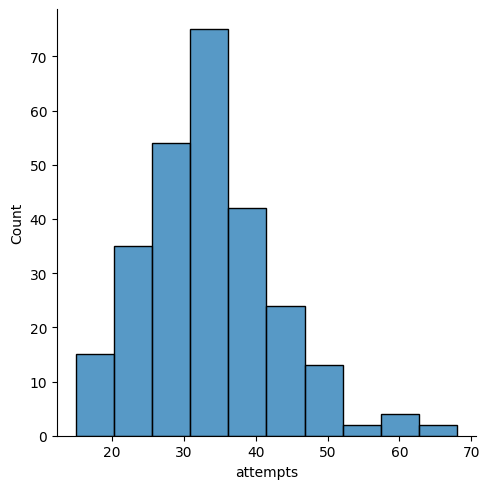

In [8]:
sns.displot(
    x="attempts",
    data=df_2022_clean,
    kind="hist",
    bins=10
)

In [9]:
df_2022_clean[['attempts', 'completions', 'comp_pct']].describe()

,attempts,completions,comp_pct
count,266.000000,266.000000,266.000000
mean,33.563910,21.646617,64.454474
std,9.134924,6.507697,9.164460
min,15.000000,5.000000,31.250000
25%,27.000000,17.250000,59.090000
50%,33.000000,21.000000,64.520000
75%,39.000000,25.000000,70.695000
max,68.000000,43.000000,90.910000


In [10]:
# Geno Smith's games
df_2022_clean[df_2022_clean['player_name'] == 'Geno Smith'][['week', 'completions', 'attempts', 'comp_pct']]

,week,completions,attempts,comp_pct
63,1,23,28,82.14
64,2,24,30,80.00
65,3,32,44,72.73
66,4,23,30,76.67
67,5,16,25,64.00
68,6,20,31,64.52
69,7,20,27,74.07
70,8,23,34,67.65
71,9,26,34,76.47


In [11]:
# Aggregate by week to find the average completion percentage per week
# Make sure to leave out Geno Smith to get the true average of his peers
by_week = df_2022_clean[df_2022_clean['player_name'] != 'Geno Smith'] \
    .groupby('week') \
    .mean() \
    .reset_index()

by_player_week = df_2022_clean \
    .groupby(['week', 'player_name']) \
    .mean() \
    .reset_index()

/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_59043/2864774432.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean() \
/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_59043/2864774432.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean() \


In [12]:
by_week

,week,completions,attempts,comp_pct,pass_yds,pass_tds,int,pass_air_yds,fantasy_pts,games_played
0,1,22.354839,35.129032,63.452258,245.225806,1.580645,0.870968,259.161290,16.692903,6.838710
1,2,22.400000,34.833333,64.327667,242.833333,1.800000,0.833333,264.400000,17.910000,7.066667
2,3,22.516129,35.645161,63.221935,251.870968,1.193548,0.677419,290.032258,15.597419,7.096774
3,4,20.310345,31.931034,62.921724,230.310345,1.379310,0.793103,243.413793,15.381379,7.275862
4,5,21.709677,33.741935,64.595161,239.096774,0.935484,0.645161,254.677419,14.625161,7.129032
5,6,21.307692,33.538462,63.316154,218.961538,1.307692,0.615385,233.038462,14.712308,7.000000
6,7,22.500000,33.538462,67.344615,246.076923,1.192308,0.730769,245.769231,15.300769,6.653846
7,8,21.178571,31.857143,66.893929,239.142857,1.535714,0.750000,248.750000,17.040714,6.857143
8,9,19.760000,31.920000,61.300800,199.640000,1.320000,0.560000,245.760000,16.297600,7.040000


In [13]:
by_player_week[by_player_week['player_name'] == 'Geno Smith']

,week,player_name,completions,attempts,comp_pct,pass_yds,pass_tds,int,pass_air_yds,fantasy_pts,games_played
7,1,Geno Smith,23.0,28.0,82.14,195.0,2.0,0.0,144.0,17.20,9.0
39,2,Geno Smith,24.0,30.0,80.00,197.0,0.0,1.0,162.0,6.08,9.0
70,3,Geno Smith,32.0,44.0,72.73,325.0,2.0,1.0,412.0,18.90,9.0
103,4,Geno Smith,23.0,30.0,76.67,320.0,2.0,0.0,320.0,31.70,9.0
134,5,Geno Smith,16.0,25.0,64.00,268.0,3.0,0.0,294.0,24.02,9.0
163,6,Geno Smith,20.0,31.0,64.52,197.0,0.0,0.0,213.0,12.68,9.0
192,7,Geno Smith,20.0,27.0,74.07,210.0,2.0,1.0,206.0,13.10,9.0
217,8,Geno Smith,23.0,34.0,67.65,212.0,2.0,0.0,273.0,19.08,9.0
245,9,Geno Smith,26.0,34.0,76.47,275.0,2.0,1.0,103.0,20.80,9.0


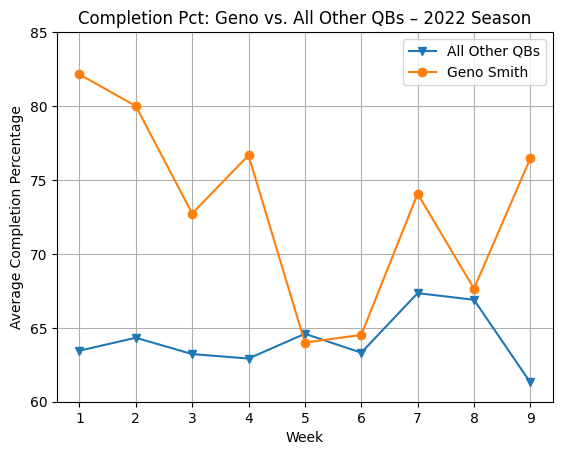

In [61]:
plt.plot(
    'week', 
    'comp_pct', 
    data=by_week,
    marker='v', 
    label='All Other QBs',)
plt.plot(
    'week', 
    'comp_pct', 
    data=by_player_week[by_player_week['player_name'] == 'Geno Smith'],
    marker='o',
    label='Geno Smith')

plt.xlabel('Week')
plt.ylabel('Average Completion Percentage')
plt.title('Completion Pct: Geno vs. All Other QBs – 2022 Season')

plt.legend(loc="upper right")
plt.ylim(60,85)
plt.grid()

plt.show()

Here's what I wrote after Week 7: "Geno started out hot, reverted to the mean weeks 5-6 and rebounded Week 7. Overall, he is having quite a season, doing quite a bit better than the league average in terms of completion percentage."

Geno is still outperforming the competition! He is trending up while the other QBs are trending down.

In [27]:
# Get the top 5 QBs by average completion percentage
df_2022_clean.groupby('player_name')[['comp_pct','games_played']] \
    .mean() \
    .sort_values('comp_pct', ascending=False)[:5]

,comp_pct,games_played
player_name,,
Geno Smith,73.138889,9.0
Tua Tagovailoa,70.746667,6.0
Bailey Zappe,70.462500,4.0
Joe Burrow,70.282222,9.0
Jalen Hurts,68.105000,8.0


Geno does indeed have the highest average completion percentage among NFL QBs this season. Controlling for games played, he's beating Joe Burrow by ~4.5%, who has also started every game.

## Geno vs. The Field: 1999-2022
Below is a recreation of the above analysis using data from [nflverse](https://nflverse.nflverse.com) going back to 1999. Is Geno Smith having a historic season?

In [16]:
# Get data for all seasons

query = """
SELECT
    player_id,
    player_display_name AS player_name,
    season,
    week,
    completions,
    attempts,
    ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
    passing_yards AS pass_yds,
    passing_tds AS pass_tds,
    interceptions AS int,
    passing_air_yards AS pass_air_yds,
    ROUND(fantasy_points,2) AS fantasy_pts,
    COUNT() OVER(PARTITION BY player_name, season) AS games_played
FROM weekly 
WHERE week <= 9
    AND position = 'QB'
    AND season_type = 'REG'
    AND attempts >= 15
"""

df_all = pd.read_sql(query, conn)

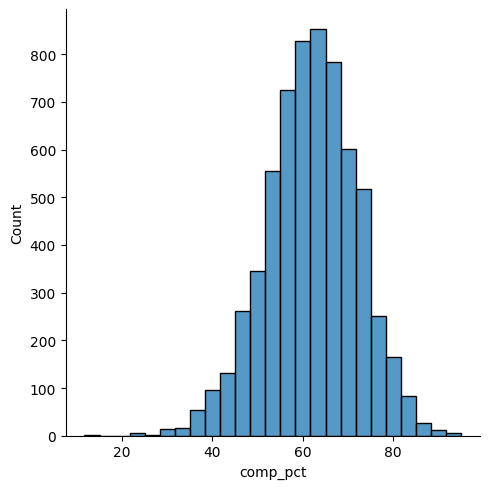

In [17]:
# Check distribution

sns.displot(
    x="comp_pct",
    data=df_all,
    kind="hist",
    bins=25
)

In [18]:
df_all[['comp_pct','attempts','completions']].describe()

,comp_pct,attempts,completions
count,6326.000000,6326.000000,6326.000000
mean,61.956320,32.905628,20.411002
std,10.034501,8.741620,6.280120
min,11.760000,15.000000,2.000000
25%,55.560000,27.000000,16.000000
50%,62.160000,33.000000,20.000000
75%,68.750000,39.000000,24.000000
max,95.000000,68.000000,45.000000


In [19]:
# Filter out Geno's data for this season
geno_2022 = (df_all['player_name'] == 'Geno Smith') & (df_all['season'] == 2022)

by_week_all = df_all[~geno_2022].groupby('week').mean().reset_index()

/var/folders/pr/phs5jp1d143fx1t05hqzwt580000gn/T/ipykernel_59043/3040588277.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_week_all = df_all[~geno_2022].groupby('week').mean().reset_index()


In [29]:
by_week_all[['comp_pct', 'pass_yds', 'pass_tds', 'fantasy_pts']].round(2)

,comp_pct,pass_yds,pass_tds,fantasy_pts
0,62.36,234.74,1.43,14.66
1,62.04,235.57,1.42,14.92
2,62.71,238.12,1.40,15.00
3,62.08,236.95,1.44,14.88
4,61.87,235.51,1.42,14.81
5,61.55,235.29,1.39,14.58
6,61.38,225.09,1.36,14.16
7,61.70,230.02,1.44,14.88
8,61.63,230.83,1.46,14.96


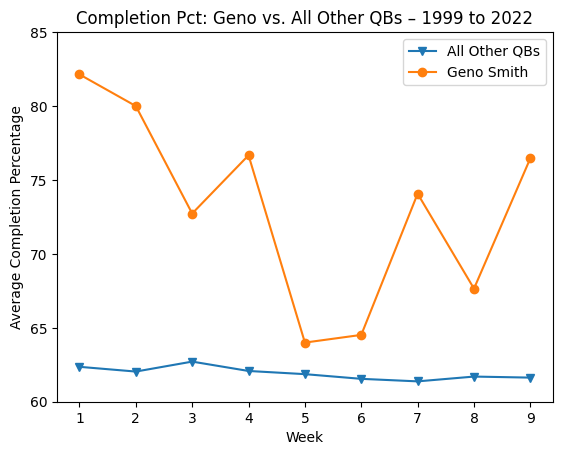

In [21]:
plt.plot(
    'week', 
    'comp_pct', 
    data=by_week_all,
    marker='v', 
    label='All Other QBs',)
plt.plot(
    'week', 
    'comp_pct', 
    data=by_player_week[by_player_week['player_name'] == 'Geno Smith'],
    marker='o',
    label='Geno Smith')

plt.xlabel('Week')
plt.ylabel('Average Completion Percentage')
plt.title('Completion Pct: Geno vs. All Other QBs – 1999 to 2022')

plt.legend(loc="upper right")
plt.ylim(60,85)

plt.show()

### Ranking Geno's 2022 Season

In [22]:
# Get data for all seasons

query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        season,
        week,
        completions,
        attempts,
        ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
        passing_yards AS pass_yds,
        passing_tds AS pass_tds,
        interceptions AS int,
        passing_air_yards AS pass_air_yds,
        ROUND(fantasy_points,2) AS fantasy_pts
    FROM weekly 
    WHERE week <= 9
        AND position = 'QB'
        AND season_type = 'REG'
        AND attempts >= 15
)
SELECT
    player_name,
    season,
    week,
    attempts,
    completions,
    comp_pct,
    COUNT() OVER(PARTITION BY player_name, season) AS games_played,
    fantasy_pts,
    RANK() OVER(PARTITION BY week ORDER BY comp_pct DESC) AS r_comp_pct_by_week
FROM data
"""

df_best = pd.read_sql(query, conn)

In [30]:
best_per_week = df_best[df_best['r_comp_pct_by_week'] == 1]
best_per_week.sort_values('week')

,player_name,season,week,attempts,completions,comp_pct,games_played,fantasy_pts,r_comp_pct_by_week
2444,Gardner Minshew,2020,1,20,19,95.00,7,20.82,1
3806,Kurt Warner,2009,2,26,24,92.31,8,17.62,1
5368,Ryan Fitzpatrick,2020,3,20,18,90.00,6,24.20,1
5637,Steve McNair,2003,4,16,15,93.75,8,18.94,1
2247,Drew Brees,2018,5,29,26,89.66,8,26.72,1
6173,Trevor Lawrence,2022,6,22,20,90.91,9,24.90,1
5407,Ryan Tannehill,2015,7,19,18,94.74,8,27.58,1
220,Alex Smith,2012,8,19,18,94.74,8,21.88,1
4991,Philip Rivers,2012,9,20,18,90.00,8,14.60,1


In [31]:
df_best[(df_best['player_name'] == 'Geno Smith') & (df_best['season'] == 2022)]

,player_name,season,week,attempts,completions,comp_pct,games_played,fantasy_pts,r_comp_pct_by_week
2472,Geno Smith,2022,1,28,23,82.14,9,17.20,13
2473,Geno Smith,2022,2,30,24,80.00,9,6.08,25
2474,Geno Smith,2022,3,44,32,72.73,9,18.90,103
2475,Geno Smith,2022,4,30,23,76.67,9,31.70,51
2476,Geno Smith,2022,5,25,16,64.00,9,24.02,291
2477,Geno Smith,2022,6,31,20,64.52,9,12.68,256
2478,Geno Smith,2022,7,27,20,74.07,9,13.10,76
2479,Geno Smith,2022,8,34,23,67.65,9,19.08,185
2480,Geno Smith,2022,9,34,26,76.47,9,20.80,38


For all the talk, none of Geno's weekly performances in the 2022 even crack the top 10 in terms of completion percentages. However, if we compare the number of attempts by Geno Smith vs. the top performers, we see a big discrepancy – the best performers only threw 20-25 times! Geno throws around 25-35 times a game.

Increasing the attempts threshold from 15 to 25 and re-running the rankings will make for a better comparison.

In [37]:
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        season,
        week,
        completions,
        attempts,
        ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
        passing_yards AS pass_yds,
        passing_tds AS pass_tds,
        interceptions AS int,
        passing_air_yards AS pass_air_yds,
        ROUND(fantasy_points,2) AS fantasy_pts
    FROM weekly 
    WHERE week <= 9
        AND position = 'QB'
        AND season_type = 'REG'
        AND attempts >= 25
)
SELECT
    player_name,
    season,
    week,
    attempts,
    completions,
    comp_pct,
    COUNT() OVER(PARTITION BY player_name, season) AS games_played,
    fantasy_pts,
    RANK() OVER(PARTITION BY week ORDER BY comp_pct DESC) AS r_comp_pct_by_week
FROM data
"""

df_best_GTE_25_att = pd.read_sql(query, conn)

df_best_GTE_25_att.sort_values('comp_pct', ascending=False).head(10)

,player_name,season,week,attempts,completions,comp_pct,games_played,fantasy_pts,r_comp_pct_by_week
3130,Kurt Warner,2009,2,26,24,92.31,8,17.62,1
1547,Derek Carr,2021,7,34,31,91.18,8,19.02,1
1521,Derek Carr,2018,2,32,29,90.63,7,15.52,2
1867,Drew Brees,2018,5,29,26,89.66,7,26.72,1
3380,Mark Brunell,2006,3,27,24,88.89,6,14.44,1
4357,Russell Wilson,2020,1,35,31,88.57,8,31.78,1
1812,Drew Brees,2011,7,35,31,88.57,9,33.00,2
3047,Kirk Cousins,2019,8,26,23,88.46,7,11.60,1
2028,Gardner Minshew,2019,1,25,22,88.00,9,17.60,2
1758,Drew Brees,2004,8,25,22,88.00,6,33.34,2


Geno doesn't show up in the top 10, even when increasing the threshold to 25 attempts.

Last chance, let's rank his average through the first 9 weeks vs. every QB's average through the first 9 weeks. Will keep the attempts threshold at 25 per game.

In [59]:
query = """
WITH data AS (
    SELECT
        player_id,
        player_display_name AS player_name,
        season,
        week,
        completions,
        attempts,
        ROUND(((completions*1.0 / attempts) * 100), 2) AS comp_pct,
        ROUND(fantasy_points,2) AS fantasy_pts
    FROM weekly 
    WHERE week <= 9
        AND position = 'QB'
        AND season_type = 'REG'
        AND attempts >= 25
), aggregations AS (
    SELECT
       player_name,
       season,
       ROUND(AVG(comp_pct), 2) AS avg_comp_pct,
       ROUND(AVG(attempts), 2) AS avg_attempts,
       COUNT(*) AS num_games,
       SUM(fantasy_pts) AS tot_fantasy_pts
    FROM data
    GROUP BY player_name, season
), rankings AS (
    SELECT
        player_name,
        season,
        avg_comp_pct,
        avg_attempts,
        tot_fantasy_pts,
        num_games,
        RANK() OVER(PARTITION BY season ORDER BY tot_fantasy_pts DESC) AS r_fantasy_pts
    FROM aggregations
)
SELECT
    player_name,
    season,
    avg_comp_pct,
    avg_attempts,
    tot_fantasy_pts
FROM rankings
WHERE num_games = 9
"""

df = pd.read_sql(query, conn)
print(df.shape)
df.sort_values('avg_comp_pct', ascending=False).head(10)


(37, 5)


,player_name,season,avg_comp_pct,avg_attempts,tot_fantasy_pts
3,Tom Brady,2007,74.21,33.22,241.34
34,Geno Smith,2022,73.14,31.44,163.56
5,Drew Brees,2011,71.53,42.11,191.56
32,Joe Burrow,2022,70.28,37.00,199.50
23,Deshaun Watson,2019,70.08,33.56,215.18
4,Drew Brees,2010,69.96,41.56,149.68
13,Philip Rivers,2015,69.46,43.33,183.52
15,Matt Ryan,2016,69.35,34.78,210.10
30,Matthew Stafford,2021,68.82,35.67,196.54
11,Ben Roethlisberger,2014,68.23,37.56,184.90


The table above shows the top 10 performances through Week 9 from 1999-2022 for QBs who played every game and had at least 25+ attempts per game, ordered by average completion percentage. I wanted to compare Geno against players with similar starts.

Like Week 7, he's second in average completion percentage but underperforming in terms of fantasy production. What's interesting is that Joe Burrow has now popped up on this list. Joe has over 30 more points than Geno (equivalent to approx. 1 games worth of points) with only 3% less completion percentage. Not bad! I wonder if Joe Burrow will keep up with Geno in terms of completion percentage throughout the season.